In [19]:
!pip install folium --quiet

In [7]:
import pandas as pd
from pymongo import MongoClient

%matplotlib inline

mongo_client = MongoClient('34.215.106.7', 27016)
database_reference = mongo_client.twitter

| | | | | |
|-|-|-|-|-|
| `_id`        | `truncated`                 |`user`            |`extended_tweet` | `favorited`                   |
| `created_at` | `in_reply_to_status_id`     |`geo`             |`quote_count`    | `retweeted`                   |
| `id`         | `in_reply_to_status_id_str` |`coordinates`     |`reply_count`    | `filter_level`                |
| `id_str`     | `in_reply_to_user_id`       |`place`           |`retweet_count`  | `lang`                        |
| `text`       | `in_reply_to_user_id_str`   |`contributors`    |`favorite_count` | `timestamp_ms`                |
| `source`     | `in_reply_to_screen_name`   |`is_quote_status` |`entities`       |                               |
























![](https://www.evernote.com/l/AAEO7gpKcKdI5YJeGrni4GhdlBiBWdTa3YgB/image.png)

In [8]:
collection_reference = database_reference.instructor_test_group

In [9]:
collection_reference.count()

20000

## Tweets By Day

In [10]:
date_from_string = {"$dateFromString" : { "dateString" : "$created_at"}}

date_to_id = {
    "$project": {
        "_id" : 0,
        "year" : {"$year": {"date" : date_from_string}},
        "month" : {"$month": {"date" : date_from_string}},
        "day" : {"$dayOfMonth": {"date" : date_from_string}},
    }
}

group_by_date = {
    "$group" : {
        "tweets" : {"$sum" : 1},
        "_id" : {
            "year" : "$year",
            "month" : "$month",
            "day" : "$day"
        },
    }
}



In [11]:
def dictionary_to_datestring(x):
    month = x['month']
    day = x['day']
    year = x['year']
    return "{}-{}-{}".format(month, day, year)

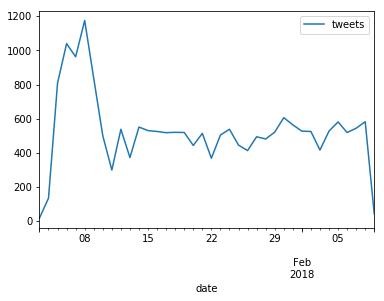

In [12]:
cursor = collection_reference.aggregate([
    date_to_id,
    group_by_date
])

daily_tweets = pd.DataFrame(list(cursor))

datestrings = daily_tweets['_id'].apply(dictionary_to_datestring)
daily_tweets['date'] = pd.to_datetime(datestrings)

daily_tweets.drop('_id', axis=1, inplace=True)
daily_tweets.sort_values('date', inplace=True)
daily_tweets.set_index('date', inplace=True)
daily_tweets.plot()

## Tweet Locations

In [13]:
nonnull_geo = {'geo' : {'$ne' : None}}
just_geo = {'geo' : 1}

cursor = collection_reference.find(nonnull_geo, just_geo)
cursor.count()

2952

In [14]:
geo_tweets = pd.DataFrame(list(cursor))

In [15]:
def parse_geo_from_tweets(tweets):
    geo = pd.DataFrame(list(tweets['geo'].values))
    return geo

In [16]:
geo = parse_geo_from_tweets(geo_tweets)
geo.sample(5)

,coordinates,type
452,"[34.0775, -118.26]",Point
118,"[36.48863024, -119.72972051]",Point
1320,"[34.0522, -118.243]",Point
1901,"[34.0522342, -118.2436849]",Point
1441,"[34.13888889, -118.3525]",Point


In [20]:
import folium
starting_loc = [34.0689, -118.4452]
la_map = folium.Map(location=starting_loc, zoom_start=13)

In [21]:
for loc in geo.coordinates.values:
    folium.Marker(loc).add_to(la_map)

In [22]:
la_map